In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cython
%matplotlib inline

In [2]:
eps = 0.01
pc_ini = np.array([.1, .5, .9])
bs = np.linspace(9/8, 3/2, num=30) + eps
seeds = np.array([i for i in range(1, 51)])
n = len(seeds)
m = len(bs)
L = 60
burn = 500 * L * L
evol = 500 * L * L

In [3]:
""" Tabulate neighbors """
NUM_NEIGHB = 9

def get_site(coord, L):
    """Get the site index from the 3-vector of coordinates."""
    # XXX: 3D hardcoded, can do N-D
    return coord[0] * L[1] + coord[1]


def get_coord(site, L):
    """Get the 3-vector of coordinates from the site index."""
    # XXX: 3D hardcoded, can do N-D
    x = site // L[1]
    y = site % L[1]
    return [x, y]


def get_neighbors(site, L):
    neighb = set()
    x, y = get_coord(site, L)
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            x1 = (x + i) % L[0]
            y1 = (y + j) % L[1]
            neighb.add(get_site([x1, y1], L))
    
    return list(neighb)
    
def tabulate_neighbors(L):
    """Tabulate the root-2 neighbors on the 3D cubic lattice with PBC."""
    Nsite = L[0]*L[1]
    neighb = np.empty((Nsite, NUM_NEIGHB), dtype=int)
    for site in range(Nsite):
        neighb[site, :] = get_neighbors(site, L)
    return neighb

def CSR_neigbours(L):
    """ Tabulate neigbors in Compressed Sparse Row format"""
    R = np.zeros(L[0] * L[1] + 1, int)
    C = np.zeros(L[0] * L[1] * NUM_NEIGHB * 2, int)
    for i in range(R.shape[0] - 1):
        R[i + 1] = R[i] + NUM_NEIGHB
        C[R[i] : R[i + 1]] = get_neighbors(i, L)
    return R, C

In [4]:
%load_ext cython

In [5]:
%%cython --annotate
import cython
import numpy as np
from rndm_wrapper cimport RndmWrapper
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def evolve_C_2(field_orig, int[:, :] neighbors, double b, int steps, int seed):
    '''
    ---Эволюция поля на Cython с RndmWrapper---
    
    принимает на вход
    - field - поле
    - b - коэффициент выигрыша
    - steps - количество шагов эволюции. За один шаг происходит эволюция одного случайного агента
    
    -------------------
    '''
    
    # обьявление переменных
    
    cdef int [:] field = field_orig.flatten() # переводим двумерный массив в одномерный
    
    cdef int N_NEIGHBR = neighbors.shape[1]
    
    cdef int step, x, n_id, j, y
    
    cdef int L = field.shape[0]
    
    cdef double scorex, scorey
    
    cdef RndmWrapper rndm = RndmWrapper(seed=(seed, 0))
    
    for step in range(steps):
        scorex = 0
        x = int(rndm.uniform() * L)
        for n_id in range(N_NEIGHBR):
            if field[neighbors[x, n_id]] == 0:
                scorex += 1
        if field[x] == 1:
            scorex *= b
        
        scorey = 0
        y = int(rndm.uniform() * N_NEIGHBR)
        y = neighbors[x, y]
        for n_id in range(N_NEIGHBR):
                if field[neighbors[y, n_id]] == 0:
                    scorey += 1
        if field[y] == 1:
            scorey *= b
        if scorey > scorex:
            field[x] = field[y]
    SHAPE = field_orig.shape
    field_orig = np.array(field)
    return np.reshape(field_orig, SHAPE)

In [6]:
def make_field(size, pc_initial):
    '''
    ---Формирование поля для одного seed---
    
    принимает на вход
    - size - размер поля
    - pc_initial - начальная плотность кооператоров
    
    возвращает
    - field - поле по заданным начальным условиям, где 1 - дефектор, 0 - кооператор
    
    ---------------------------------------
    '''
    field = np.array(np.random.rand(size, size) > pc_initial, dtype=int)
    return field
            
def calculate_pc(size, pc_initial, b, burn_steps, evol_steps, seed):
    '''
    ---Вычисление плотности кооператоров---
    
    принимает на вход
    - size
    - pc_initial
    - b
    - burn_steps - шаги отжига
    - evol_steps - шаги эволюции
    - seed - начальное условие генератора для повторяемости результата
    
    возвращает
    - pc - плотность кооператоров на протяжении evol_steps шагов
    
    ---------------------------------------
    '''
    np.random.seed(seed)
    pc = np.zeros(evol_steps)
    field = make_field(size, pc_initial)
    if seed == 1:
        print('начальная плотность кооператоров:', np.count_nonzero(field - 1) / (size * size))
    neighbors = tabulate_neighbors((L, L))
    field = evolve_C_2(field, neighbors, b, burn_steps, seed)
    if seed == 1:
        print('плотность кооператоров после отжига:', np.count_nonzero(field - 1) / (size * size))
    for step in range(evol_steps):
        field = evolve_C_2(field, neighbors, b, 1, seed)
        pc[step] = np.count_nonzero(field - 1) / (size * size)
    
    return pc

In [64]:
def write(data, file_path):
    data_line = list(np.reshape(data, data.size))
    with open(file_path, 'w', encoding='utf8') as f:
        json.dump(data_line, f)
    
def read(data_shape, file_path):
    with open(file_path, 'r', encoding='utf8') as f:
        data_copy = np.reshape(np.array(json.load(f)), data_shape)
    return data_copy

Для исследования модификации игры на данном этапе необходимо для каждой начальной плотности кооператоров рассмотреть два графика:

1. График зависимости плотности от времени. Плотность усредняется по реализациям.
2. График зависимости плотности от $b$. Плотность усредняется по времени и реализациям. Вычисляются стандартные ошибки среднего для каждого $b$.

### Стандартная ошибка среднего (по реализациям)

Вычисляется как $\frac{\sqrt{\frac{1}{n}\sum\limits_{j=1}^n{(\rho_j - \overline{\rho})}^2}}{\sqrt{n}}$, где

$\rho_j$ - значение плотности по шагам для одной реализации

$\overline{\rho}$ - среднее значение плотности по шагам и по реализациям

$n$ - количество реализаций

# ${\rho_c}_{ini} = 0.5$

In [7]:
pc1 = np.zeros((m, evol))
err1 = np.zeros(m)
p_tilda1 = np.zeros(m)
for i in range(m):
    pc_temp = np.zeros((n, evol))
    for j in range(n):
        pc_temp[j] = calculate_pc(L, pc_ini[1], bs[i], burn, evol, seeds[j])
    pc1[i] = np.mean(pc_temp, axis=0)
    
    p_j = np.mean(pc_temp, axis=1)
    p_tilda1[i] = np.mean(pc_temp)
    err1[i] = np.sqrt((sum(p_j - p_tilda1[i]) ** 2) / n) / np.sqrt(n)
    print('\n', i, '\n-----', sep='')

начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.9927777777777778

0
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.7213888888888889

1
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.7213888888888889

2
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.5886111111111111

3
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.5886111111111111

4
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.5886111111111111

5
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.5141666666666667

6
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.5141666666666667

7
-----
начальная плотность кооператоров: 0.4955555555555556
пло

KeyboardInterrupt: 

In [26]:
for i in range(21, m):
    pc_temp = np.zeros((n, evol))
    for j in range(n):
        pc_temp[j] = calculate_pc(L, pc_ini[1], bs[i], burn, evol, seeds[j])
    pc1[i] = np.mean(pc_temp, axis=0)
    
    p_j = np.mean(pc_temp, axis=1)
    p_tilda1[i] = np.mean(pc_temp)
    err1[i] = np.sqrt((sum(p_j - p_tilda1[i]) ** 2) / n) / np.sqrt(n)
    print('\n', i, '\n-----', sep='')

начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.0

21
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.0

22
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.0

23
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.0

24
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.0

25
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.0

26
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.0

27
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.0

28
-----
начальная плотность кооператоров: 0.4955555555555556
плотность кооператоров после отжига: 0.0

29
-----


In [65]:
write(pc1, 'pc1.txt')
write(p_tilda1, 'p_tilda1.txt')
write(err1, 'err1.txt')

In [66]:
pc1_copy = read((m, evol), 'pc1.txt')
p_tilda1_copy = read((m,), 'p_tilda1.txt')
err1_copy = read((m,), 'err1.txt')

C:\Users\79155\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


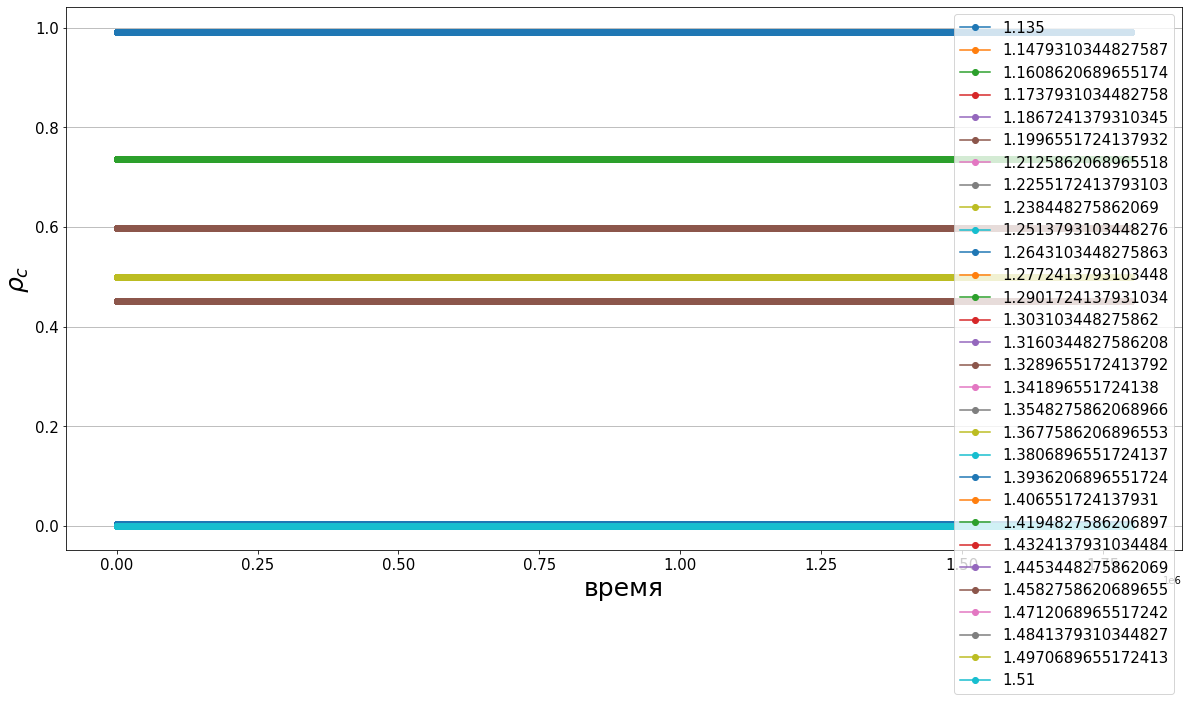

In [69]:
#График зависимости плотности от количества шагов эволюции
fig, ax = plt.subplots(1,1,figsize=(20,10))
for i in range(m):
    ax.plot(pc1_copy[i], 'o-', label=bs[i])

ax.set_xlabel('время',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

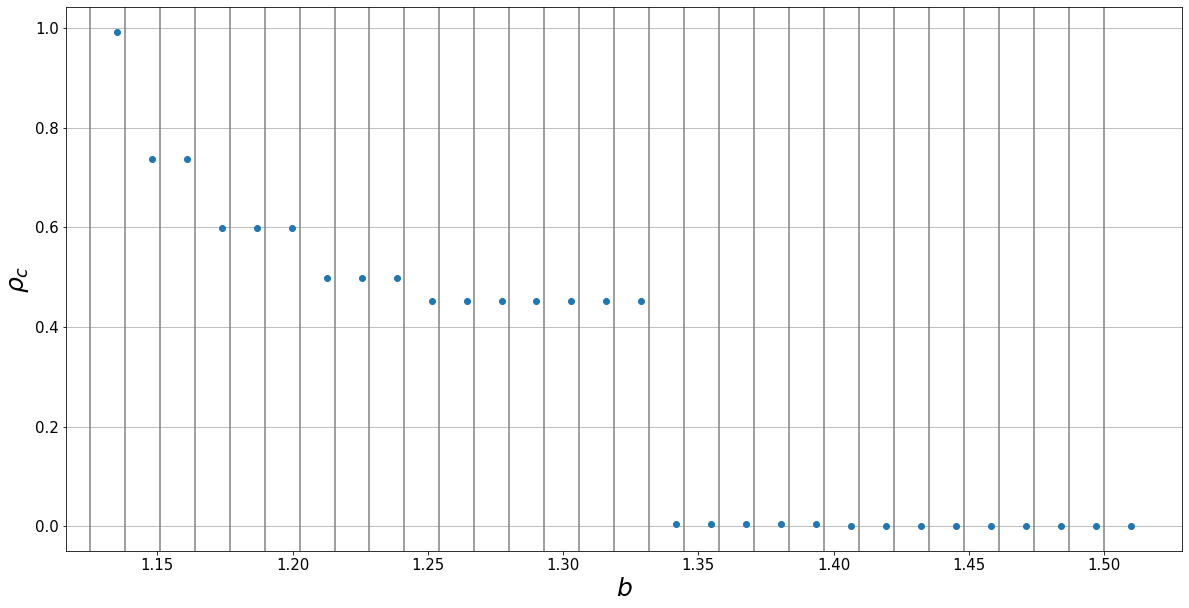

In [70]:
#График зависимости плотности от b
fig,ax = plt.subplots(1, 1, figsize=(20, 10))
ax.errorbar(bs, p_tilda1_copy, err1_copy, fmt='o', capsize=3)
ax.set_xlabel('$%s$'%'b',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
for i in range(m):
    ax.axvline(bs[i] - eps, color='grey')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

# ${\rho_c}_{ini} = 0.9$

In [27]:
bs_short = np.linspace(9/8, 3/2, num=15) + eps
m_short = len(bs_short)

pc2 = np.zeros((m_short, evol))
err2 = np.zeros(m_short)
p_tilda2 = np.zeros(m_short)
for i in range(m_short):
    pc_temp = np.zeros((n, evol))
    for j in range(n):
        pc_temp[j] = calculate_pc(L, pc_ini[2], bs_short[i], burn, evol, seeds[j])
    pc2[i] = np.mean(pc_temp, axis=0)
    
    p_j = np.mean(pc_temp, axis=1)
    p_tilda2[i] = np.mean(pc_temp)
    err2[i] = np.sqrt((sum(p_j - p_tilda2[i]) ** 2) / n) / np.sqrt(n)
    print('\n', i, '\n-----', sep='')

начальная плотность кооператоров: 0.9008333333333334
плотность кооператоров после отжига: 0.9927777777777778

0
-----
начальная плотность кооператоров: 0.9008333333333334
плотность кооператоров после отжига: 0.7375

1
-----
начальная плотность кооператоров: 0.9008333333333334
плотность кооператоров после отжига: 0.6163888888888889

2
-----
начальная плотность кооператоров: 0.9008333333333334
плотность кооператоров после отжига: 0.5080555555555556

3
-----
начальная плотность кооператоров: 0.9008333333333334
плотность кооператоров после отжига: 0.5080555555555556

4
-----
начальная плотность кооператоров: 0.9008333333333334
плотность кооператоров после отжига: 0.45611111111111113

5
-----
начальная плотность кооператоров: 0.9008333333333334
плотность кооператоров после отжига: 0.45611111111111113

6
-----
начальная плотность кооператоров: 0.9008333333333334
плотность кооператоров после отжига: 0.45611111111111113

7
-----
начальная плотность кооператоров: 0.9008333333333334
плотность ко

In [72]:
write(pc2, 'pc2.txt')
write(p_tilda2, 'p_tilda2.txt')
write(err2, 'err2.txt')

In [73]:
pc2_copy = read((m_short, evol), 'pc2.txt')
p_tilda2_copy = read((m_short,), 'p_tilda2.txt')
err2_copy = read((m_short,), 'err2.txt')

C:\Users\79155\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


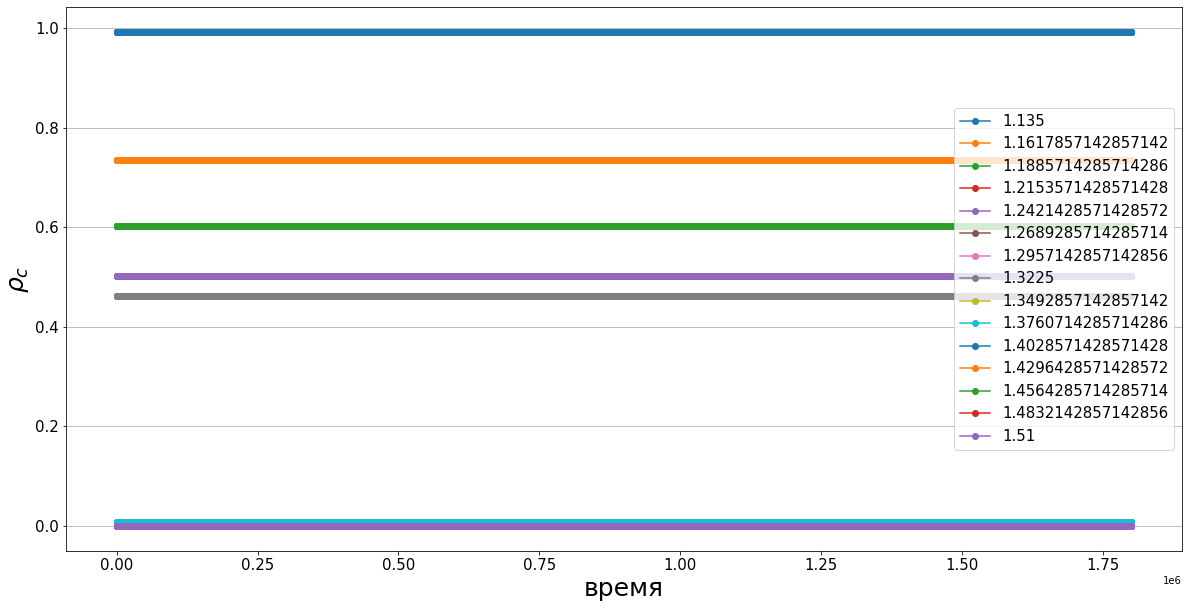

In [75]:
#График зависимости плотности от количества шагов эволюции
fig, ax = plt.subplots(1,1,figsize=(20,10))
for i in range(m_short):
    ax.plot(pc2_copy[i], 'o-', label=bs_short[i])

ax.set_xlabel('время',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

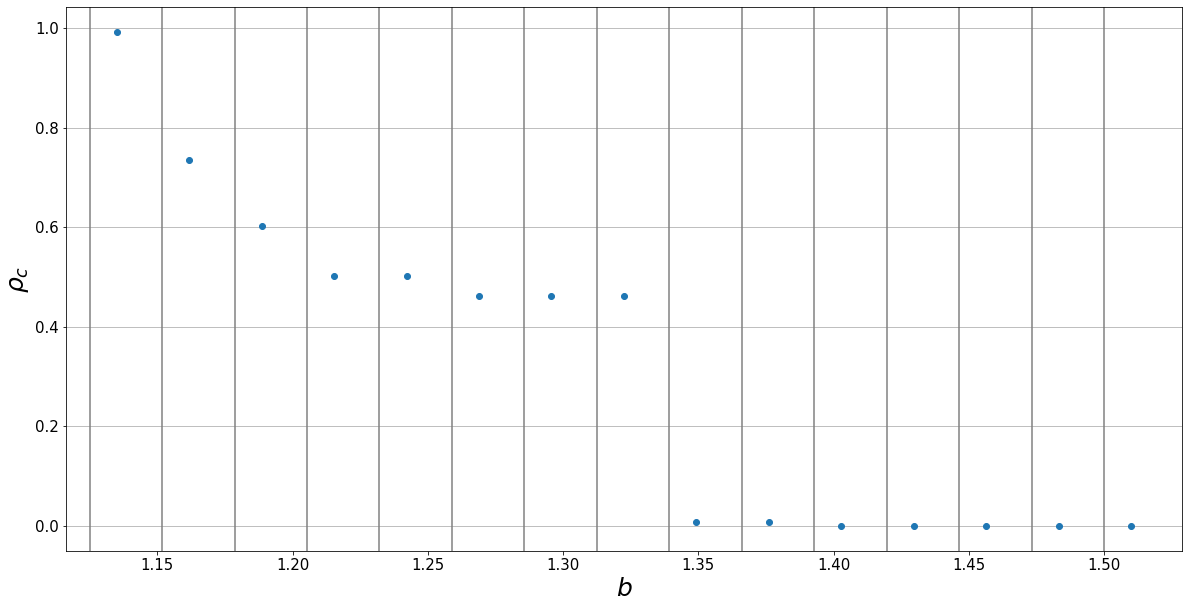

In [76]:
#График зависимости плотности от b
fig,ax = plt.subplots(1, 1, figsize=(20, 10))
ax.errorbar(bs_short, p_tilda2_copy, err2_copy, fmt='o', capsize=3)
ax.set_xlabel('$%s$'%'b',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
for i in range(m_short):
    ax.axvline(bs_short[i] - eps, color='grey')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')